**Machine Learning Basic Principles 2018 - Data Analysis Project Report**

# Using supervised PCA with SVM for music genre classification 

## Abstract

This data analysis project focuses on a multiclass music genre classification problem. Pre-extracted summary characteristics of the data are further preprocessed using a median absolute deviation based feature selection method and supervised principal component analysis. The prediction power of a support vector machine is optimized using micro-averaged f1-score and multiclass logarithmic loss as evaluation metrics. Majority classes are predicted successfully, while compromising the prediction accuracy of minority classes. This is deemed acceptable as the data is significantly skewed.

## 1. Introduction

This data analysis project is a part of a Aalto University course, Machine Learning: Basic Principles [1]. The aim is to construct a machine learning solution that is able to classify the music genre of songs. Realistically, songs are often a mix of multiple genres that would result in a multilable classification problem. In our case only one genre is assigned to a song, simplifying the task to a multiclass classification problem with only 10 genres: 1—pop-rock, 2—electronic, 3—rap, 4—jazz, 5—latin, 6—RnB, 7—international, 8—country, 9—reggae, 10—blues. The dataset is a custom subset of the Million Song Dataset, and the labels are obtained from AllMusic.com. The 264 features analyzed are pre-extracted by the course staff and are a summary representation of the three main components of music: timbre, pitch and rhythm. The training and test data consist of 4363 and 6544 songs respectively. The resulting machine learning solution is benchmarked on two categories: accuracy and multiclass logarithmic loss.

The data will first be prepossessed and then a support vector machine (SVM) will be trained and optimized on it. Feature selection will be implemented using a robust statistical measure, the median absolute deviation (MAD). Supervised principal component analysis (sPCA) will be used for embedding the feature space. SVM is a versatile model and will be separately optimized for maximizing accuracy and minimizing logistic loss. 

This project relies heavily on the Python scikit-learn library [2]. The project explores the reach of sPCA combined with SVM for a multiclass classification problem. Similar tasks of genre classification are tackled in all modern media-players like Spotify and Apple Music. Audio classification in general is a vast field in signal analysis and can be applied to many fields of entertainment and military.

## 2. Data analysis

Since this is a supervised problem, the class distribution is known and is visualized in Figure (1) as a histogram with density as the y-axis. Both the train and data sets are random subsets of a much larger one, and thus the class distributions are believed to be similar. The data at hand is skewed, with $50\%$ of the data belonging to class 1. Class 2 is also heavily represented compared to classes 3-10. The interpretation is that around $65\%$ of the songs are either pop-rock or electronic, which makes sense since they are currently the dominant genres. 

This imbalanced data set makes any classifier prone to over-fitting, since it is trivial to achieve decent accuracy by only guessing class 1. This can be combated by undersampling the majority class, oversampling the minority class, by assigning weights to classes or by doing nothing [3]. The selected approach should reflect the preferred outcome, which in our case is overall accuracy and logarithmic loss. 

In [1]:
# ----------IMPORT LIBRARIES---------------------
%matplotlib inline
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from statsmodels import robust
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import get
import sPCA

# ----------IMPORT DATA--------------------------
DATA = get.matrix('train_data.csv', 0)
LABELS = get.vector('train_labels.csv', 0)

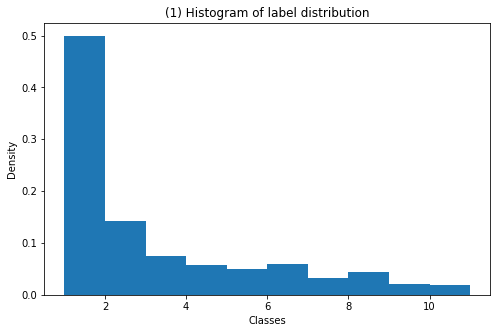

In [3]:
# plot histogram
plt.figure(figsize=(8,5))
plt.hist(LABELS, bins=[1,2,3,4,5,6,7,8,9,10,11], density=True)
plt.title("(1) Histogram of label distribution")
plt.ylabel('Density')
plt.xlabel('Classes')
plt.show()

## 3. Methods and experiments

### 3.1 Evaluation metrics

When combating imbalanced data, it is crucial to use the correct evaluation metric for the task. When optimizing a machine learning model, it should be benchmarked correctly at each phase. There are numerous metrics available including accuracy, precision, recall, f1-score, roc-auc (area under receiver operating characteristic curve) and pr-auc (area under precision-recall curve) [4,5].

Precision is the number of correct positive results divided by the number of all positive results returned by the classifier, and recall is the number of correct positive results divided by the number of all relevant samples, i.e, all samples that should have been identified as positive. F1-score is simply the harmonic average of precision and recall. These metrics use the cut-off threshold of 0.5.

Roc-auc and pr-auc are more sophisticated metrics that provide more information about the model, since they are not limited to the cut-off threshold of 0.5. They operate in the whole \{0,1\} threshold space. Roc-auc emphasizes recall, and pr-auc precision.

For correct minority-class detection a model should be optimized for recall. For correct majority-class detection a model should be optimized for precision. Since we are interested in both, the best metric for this task is the f1-score. 

Both precision and recall and thus the f1-score is defined in the binary case. To extend the concept to a multiclass setting, either micro- or macro-averaging method should be used. A macro-average will compute the metric independently for each class and then take the average, treating all classes equally. Whereas a micro-average will aggregate the contributions of all classes to compute the average metric. Since our data is imbalanced, the micro-averaging should be used. 

This line of reasoning leads to the choice of micro-averaged f1-score, which incidentally is identical to accuracy in our case [6]. So trivially, accuracy will be used as a metric for maximizing accuracy. If this would have been a multilable task, the micro-averaged f1-score would not have been equal to accuracy.

For the multiclass logarithmic loss, the evaluation metric will be scikit-learns log-loss metric defined as

\begin{equation*}
    \log P(y_t | y_p)  =  y\log(p) + (1 - y)\log(1 - p),
\end{equation*}

with $y_t$ and $y_p$ denoting the true and predicted label respectively. This metric punishes the classifiers errors in the probability distribution and can be extended to a multiclass setting. This is not the exact metric that will be used in Kaggle, but this is very similar and is chosen for computational benefits.

### 3.2 Preprocessing

#### 3.2.1. Combating imbalanced data

As mentioned previously there are several ways to combat imbalanced data: undersampling the majority class, oversampling the minority class or by assigning weights to classes. All of these were tried but led to poor overall accuracy and log-loss, so nothing was done in this regard.

Undersampling lead to loss of information and thus poor accuracy across all classes. Whereas oversampling lead to better accuracy in minority classes, but poor overall accuracy. This was caused by the drop of accuracy of class 1, resulting in misclassification of a much larger portion of the samples. SMOTE (Synthetic Minority Over-sampling Technique) was used for oversampling [7]. Assigning weights to the minority classes resulted in similar behaviour as did oversampling. This kind of behaviour implies that the class boundaries are poorly defined. 

#### 3.2.2. Feature selection

The baseline approach to feature selection is removing all features with variance that does not meet a certain threshold. The variance of each feature is visualized in Figure (2). The figure shows that some features have extreme variance compared to others, which indicates the existence of outliers in the data. An outlier is an observation point that is distant from other observations by some metric, e.g., a highly irregular song.

Using the scikit-learn library for outlier detection, we obtain Figure (3) for demonstration purposes only. It utilizes an elliptic envelope, an object for detecting outliers in a Gaussian distributed dataset using a robust covariance matrix estimate. The figure is a scatterplot of the data points projections on the first two robust principal components with a $0.1\%$ outlier threshold. The figure shows potential outliers that are colored orange. Outliers distort variance and thus render our initial variance-based feature selection flawed.

A more sophisticated approach is introduced: feature selection by inspecting the median absolute deviation (MAD) of each feature [8]. The MAD-score of each feature is visualized in Figure (4). MAD is used because it is a robust measure of the variability of quantitative data. A robust method means that it is resilient to outliers. Generally, the lower the MAD of a feature, the less significant it is in sorting between classes. This holds true in regression but has some pitfalls in classification. A feature with low MAD can be the only separative factor between some classes, so removing it could result in the merging of classes. It is worth noting that MAD is always zero if $50\%$ of the samples are identical. The figure below shows near zero MAD for some features along the data, but especially for all features 170-264. It is highly unlikely that all of these can be safely excluded. Thus, we need to adopt a trial and error approach when using MAD as a feature selection metric.

The optimal MAD treshold is evaluated using a support vector machine introduced in Subsection 3.3.2. The prediction accuracy is maximized when we exclude only the features with a strictly zero MAD-score. The first sequence of these features are 24 features apart and correspond to the last band in each statistic, which is hardly a coincidence. The last sequence consists of 16 successive features that correspond to the last 4 pitch classes in Chroma. 

Estimated run time: 1 min


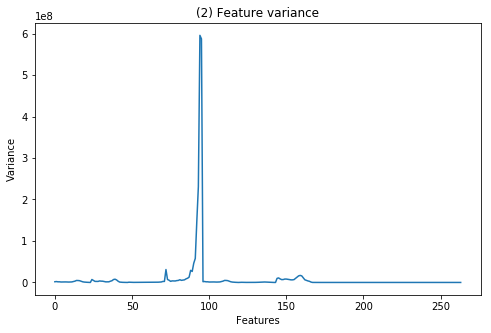

/opt/conda/lib/python3.6/site-packages/sklearn/covariance/robust_covariance.py:646: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


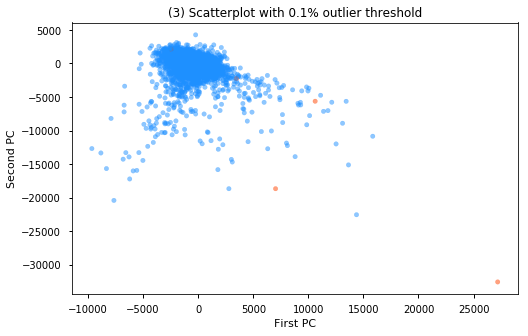

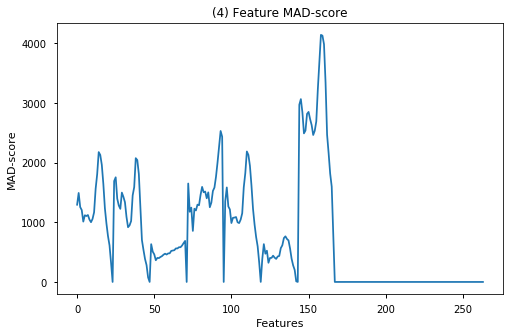

In [4]:
print('Estimated run time: 1 min')
# plot feature variance
plt.figure(figsize=(8,5))
DATA_hist = np.var(DATA, axis=0)
plt.plot(np.arange(264),DATA_hist)
plt.title("(2) Feature variance")
plt.ylabel('Variance')
plt.xlabel('Features')
plt.show()

# plot outliers
plt.figure(figsize=(8,5))
get.outlier(DATA, 0.001)
plt.title("(3) Scatterplot with 0.1% outlier threshold")
plt.ylabel('Second PC')
plt.xlabel('First PC')
plt.show()

# plot MAD-scores
plt.figure(figsize=(8,5))
DATA_mad = robust.mad(DATA)
plt.plot(np.arange(264),DATA_mad)
plt.title("(4) Feature MAD-score")
plt.ylabel('MAD-score')
plt.xlabel('Features')
plt.show()

In [7]:
# Rename data
X = DATA
y = LABELS

# Define the transform
def trimByMAD(X, tol):
    indices = []
    for i in range(X.shape[1]):
        v = X[:, i]
        r = robust.mad(v)
        if r <= tol:
            indices.append([int(i)])
    X_trimmed = np.delete(X, indices, axis=1)
    return X_trimmed

Running cross-validation for tolerance -0.01.
1 / 3
2 / 3
3 / 3
Running cross-validation for tolerance 0.
1 / 3
2 / 3
3 / 3
Running cross-validation for tolerance 1e-05.
1 / 3
2 / 3
3 / 3
Running cross-validation for tolerance 0.01.
1 / 3
2 / 3
3 / 3
Running cross-validation for tolerance 0.02.
1 / 3
2 / 3
3 / 3


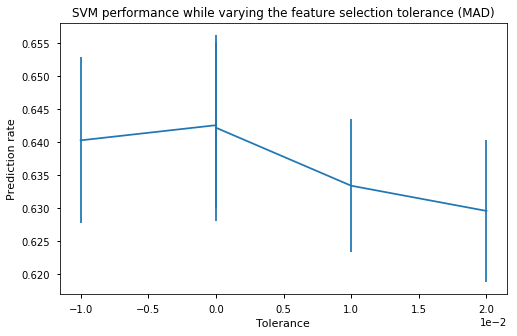

In [4]:
%matplotlib inline
plt.figure(figsize=(8,5))

# Plot the accuracy score as a function of tolerance
score_means = list()
score_stds = list()
# A negative tolerance leads to no features being removed
tolerances = (-1e-2, 0, 1e-5, 1e-2, 2e-2)

for tolerance in tolerances:
    # Random sub-sample cross-validation
    print("Running cross-validation for tolerance " + str(tolerance) + ".")
    scores_i = []
    for i in range(3):
        print(i+1,'/', 3)
        # Compute cross-validation score using 1 CPU
        X_trimmed = trimByMAD(X, tolerance)
        X_train, X_test, y_train, y_test = train_test_split(X_trimmed, y, test_size=0.2, random_state=20+i)
        X_train = preprocessing.scale(X_train)
        X_test = preprocessing.scale(X_test)

        clf = SVC(gamma='auto')
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        scores_i.append(accuracy)

    score_means.append(np.mean(scores_i))
    score_stds.append(np.std(scores_i))
    
        
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.errorbar(tolerances, score_means,  np.array(score_stds))

plt.title('SVM performance while varying the feature selection tolerance (MAD)')
plt.xlabel('Tolerance')
plt.ylabel('Prediction rate')

plt.axis('tight')
plt.show()

#### 3.2.3. Supervised PCA

Principal component analysis (PCA) is a widely used technique in multivariate statistics. It aims to explain the variance-covariance structure of data through a set of new uncorrelated variables referred to as principal components (PCs). In the classical approach, the first principal component is the direction in which the projected observations have the largest sample variance. The second component is orthogonal to the first component and corresponds to the direction which again maximizes the sample variance of the projected observations. Proceeding this way produces all of the principal components, which together reproduce the total system variability. However, much of this variability can often be accounted for by a small number of components. Thus, principal component analysis is an effective tool for data reduction.

When it comes to a classification task, the classical approach to principal component analysis has one major problem. It produces an embedding given a rather technical criterion of maximum variance. This may not result in a feature space where the classes are separated from each other. One way to tune the embedding is to add guidance, i.e., find such embedding that the dependency with respect to a response variable is maximized. In the case of a classification task, we aim to find an embedding $\mathbf{X} = \mathbf{W} \mathbf{Z}$ of the original features $\mathbf{Z}$ such that the label vector $\mathbf{y}$ depends mainly on $\mathbf{X}$. In other words, supervised PCA can be used to produce a compression matrix $\mathbf{W}$ such that observations with different labels are well separated.

The classical PCA is performed using the eigendecomposition of the matrix $\mathbf{Z}^T \mathbf{Z}$. In turn, a primitive supervised PCA consists of using the eigenvectors of $\mathbf{Z}^T \mathbf{Y} \mathbf{Y}^T \mathbf{Z}$ to project data into the transformed feature space. Here, the binary response variable $\mathbf{Y}$ is defined such that
    \begin{equation}
    y_{i,j} = \begin{cases}
        1,~ \mathbf{z}_i\in \text{class j}\\
        0,~ \text{otherwise}
    \end{cases},
    \end{equation}
where $\mathbf{z}_i$ is the $i$th observation. For details and more complex variants of supervised PCA refer to Barshan et al. 2011 [9].

The optimal number of principal components used in the embedding is evaluated using a support vector machine. The prediction accuracy of the classifier increases as the number of principal components increases. As the data set is fairly small and there is no need to compromise the model performance for decreasing computational complexity, the feature space dimension is not reduced. In other words, the dimension of the resulting feature space is equal to the dimension of the original feature space, while the classes are better separated in the embedding. 

Progress:
1 / 9
2 / 9
3 / 9
4 / 9
5 / 9
6 / 9
7 / 9
8 / 9
9 / 9


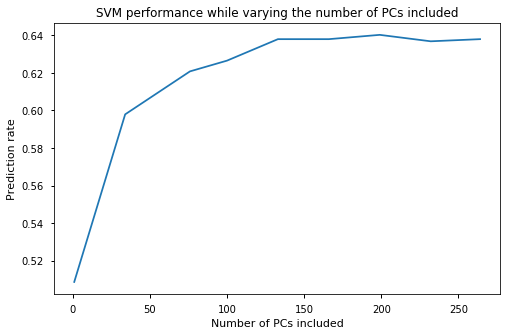

In [5]:
%matplotlib inline
# ----------CONDUCT sPCA--------------------------

X_trimmed = trimByMAD(X, 0)
X_train, X_test, y_train, y_test = train_test_split(X_trimmed, y, test_size=0.2, random_state=21)

# scale
X_train = preprocessing.scale(X_train)
X_test = preprocessing.scale(X_test)
    
PC = np.array([1,34,76,100,133,166,199,232,264])
res = []

print('Progress:')
for i in range(PC.shape[0]):
    print(i+1,'/',9)
    # get transformation matrix P
    j = PC[i]
    P, e = sPCA.compute_spca(X_train, y_train, j)
    
    # calculate scores
    train = np.dot(X_train, P)

    # encode test data
    test = np.dot(X_test, P)

    # train and predict
    mod = SVC(gamma='auto')
    mod.fit(train,y_train)
    y_pred = mod.predict(test)
    
    accu = accuracy_score(y_test, y_pred)
    res.append(accu)
    
plt.figure(figsize=(8,5))
plt.plot(PC,res)
plt.title("SVM performance while varying the number of PCs included")
plt.ylabel('Prediction rate')
plt.xlabel('Number of PCs included')
plt.show()

In [9]:
# exclude zero-MAD features
X_trimmed = trimByMAD(X, 0)

# scale
X_train = preprocessing.scale(X_trimmed)

# ----------CONDUCT sPCA--------------------------
# conduct sPCA
P, e = sPCA.compute_spca(X_train, y, 241)

# calculate scores
X_train = np.dot(X_train, P)

### 3.3 Classification

#### 3.3.1. Grid search

In this project, the model validation and the parameter tuning are based on splitting the available labeled data into training and validation sets. This process is repeated with varying subsets and the classification results are averaged in order to assess how well they will generalize to an independent data set. This is referred to as cross-validation. In particular, two different cross-validation methods are used: repeated random sub-sampling validation and $k$-fold cross validation. In repeated random sub-sampling the labeled data is randomly split into training and validation data. The disadvantage of this method is that some observations may never be used in the model validation while some observations may appear in the validation data multiple times. In k-fold cross validation the labeled data is randomly partitioned into $k$ equal sized subsets. Of these subsets, one at a time is used as the validation data while the remaining $k-1$ subsets are used as training data. The process is repeated $k$ times such that every observation is used in model validation exactly once.

In parameter tuning, we perform an exhaustive search over a collection of specified parameter values for a classifier. This is achieved using the scikit-learn library object GridSearchCV, which is given a classifier and an evaluation metric. The predictive performance of the classifier is optimized by cross-validated grid-search over a parameter grid. As a cross-validation method, a $k$-fold cross-validation is used.

#### 3.3.2. Classifier

The classification method is selected based on qualities of the data as well as empirical evaluation of the prediction accuracy. The two classification methods under consideration were logistic regression and support vector machine (SVM). Both methods amount to linear hypothesis space
\begin{equation}
    \mathcal{H}^{(d)} = \{ h^{(\mathbf{w})}:{\rm I\!R}^d \mapsto {\rm I\!R}:~ h^{\mathbf{w}}(\mathbf{x}) = \mathbf{w}^T \mathbf{x}, \text{ with some weight vector } \mathbf{w} \in {\rm I\!R}^d \},
\end{equation}
where $d$ is the amount of features and $\mathbf{x}$ is an individual observation. Thus, the two methods partition the feature space into $d$ subspaces (each corresponding to an individual class) using hyperplanes called decision boundaries.

Logistic regression minimizes the logistic loss function, with probabilities modeled by the sigmoid function, and SVM minimizes the hinge loss which is the best
convex approximation to the 0-1 loss function (the number of misclassified observations). Thus, we expect the classifier obtained by the SVM to yield more accurate predictions than logistic regression. In addition, logistic loss diverges faster than hinge loss. So, in general, it will be more sensitive to outliers. On the other hand, the statistical superiority of SVM leads to increased computational complexity. That said, SVM uses only a subset of training points, called support vectors, in the decision function, which makes it memory efficient. For more detailed information on the classifiers, refer to Jung 2018 [10].

As the inspected data set is fairly small, an increased computational complexity does not pose a problem. Additionally, the data contains outliers so SVM is deemed superior to logistic regression. Finally, applying kernel methods enables transformation of the feature space into a (higher dimensional) feature space where complex problems can be approached using SVM in the same linear fashion. While SVM does not directly provide probability estimates, these can be calculated using an expensive five-fold cross-validation. This option is implemented in the SVC method of the scikit-learn library. Accordingly, SVC method is the SVM implementation used in this project.


#### 3.3.3. Maximizing accuracy

As discussed in Subsection 3.1, accuracy is used as an evaluation metric for maximizing prediction accuracy. The three SVC parameters tuned are 'kernel', 'gamma' and 'C'. Kernel parameter selects the type of hyperplanes used to separate the data. Option 'linear' referes to linear hyperplanes and options 'rbf' and 'poly' to non-linear hyperplanes. Parameter 'gamma' affects the non-linear kernels. It concerns the influense of a single training observation on the model such that the higher the 'gamma' value is, the more exactly the training data is fit. Finally, the parameter 'C' controls the trade off between correct classification of training data and a smooth decision boundary. Thus, it behaves as an SVM regularization parameter. Increasing 'gamma' and 'C' values may lead to overfitting and to a less generalizable model.

First, we tune the 'kernel' and 'gamma' parameters. Kernel 'rbf' and 'gamma' value 'auto', that is multiplicative inverse of the amount of features, prove optimal. Then, to locate the magnitude of the optimal 'C' value, a sparse grid search is performed on a $[0.1, 10]$ interval. The figures below shows that the test data accuracy reaches a plateau of approximately 0.6 soon after 'C' value of 1. On the other hand, training data accuracy increases up to 1 as the 'C' value increases. This is a clear sign of overfitting. We perform a grid search over a $[2,5]$ interval. The figure below shows that the cross validation error starts to increase soon after 'C' value 2.5. This is why we adopt an empirical approach and fine-tune the parameter 'C' based on the score we get from Kaggle.

In [7]:
# ----------OPTIMIZE SVM--------------------------
# optimizing kernel and gamma-value
param_test1 = {
    'kernel': ['linear','poly','rbf','sigmoid'],
    'gamma': ['auto', 'scale']
}

scoring = {'Accuracy': 'accuracy'}

search = GridSearchCV(estimator = SVC(),
                        param_grid=param_test1,
                        scoring=scoring,
                        refit='Accuracy',
                        n_jobs=-1,
                        iid=False,
                        cv=3)

print('Estimated run time: 2 min')
search.fit(X_train,y)
print('Optimal parameters and corresponding accuracy:')
print(search.best_params_)
print(search.best_score_)

Estimated run time: 2 min
Optimal parameters and corresponding accuracy:
{'gamma': 'auto', 'kernel': 'rbf'}
0.628911230304


In [8]:
# ----------OPTIMIZE SVM--------------------------
param_test2 = {
    'C':list(np.linspace(0.1, 10, num=10)),
}

scoring = {'Accuracy': 'accuracy'}

search = GridSearchCV(estimator = SVC(kernel='rbf', gamma='auto'),
                        param_grid=param_test2,
                        scoring=scoring,
                        refit='Accuracy',
                        n_jobs=-1,
                        iid=False,
                        return_train_score=True,
                        cv=3)

print('Estimated run time: 2 min')
search.fit(X_train,y)
print('Optimal parameters and corresponding accuracy:')
print(search.best_params_)
print(search.best_score_)

Estimated run time: 2 min
Optimal parameters and corresponding accuracy:
{'C': 3.4000000000000004}
0.654836895377


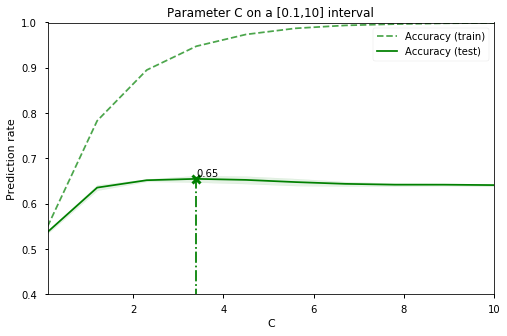

In [9]:
# plot prediction rate
%matplotlib inline
get.plot_gsearch(search, [0.1,10], [0.4,1], 'Parameter C on a [0.1,10] interval', scoring)

In [10]:
# ----------OPTIMIZE SVM--------------------------
param_test3 = {
    'C':list(np.linspace(2, 5, num=10)),
}

scoring = {'Accuracy': 'accuracy'}

search = GridSearchCV(estimator = SVC(kernel='rbf', gamma='auto'),
                        param_grid=param_test3,
                        scoring=scoring,
                        refit='Accuracy',
                        n_jobs=-1,
                        iid=False,
                        return_train_score=True,
                        cv=3)

print('Estimated run time: 2 min')
search.fit(X_train,y)
print('Optimal parameters and corresponding accuracy:')
print(search.best_params_)
print(search.best_score_)

Estimated run time: 2 min
Optimal parameters and corresponding accuracy:
{'C': 4.0}
0.656212102577


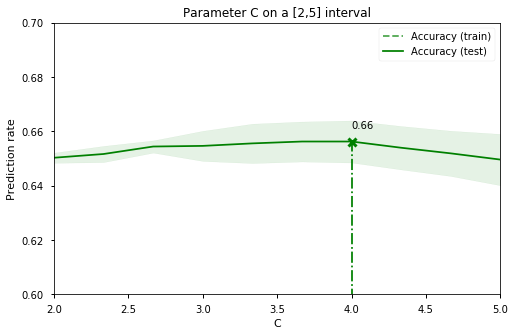

In [11]:
# plot prediction rate
%matplotlib inline
get.plot_gsearch(search, [2,5], [0.6,0.7], 'Parameter C on a [2,5] interval', scoring)

#### 3.3.4. Minimizing logarithmic loss

As discussed in Subsection 3.1, multilabel logarithmic loss is minimized using scikit-learns log-loss as an evaluation metric. As when maximizing accuracy, we first tune the 'kernel' and 'gamma' parameters. Once again, kernel 'rbf' and 'gamma' value 'auto' prove optimal. Then, to locate the magnitude of the optimal 'C' value, a sparse grid search is performed on a  $[0.1,10]$  interval. The resulting figure is depicted below. A denser grid search is performed in the vicinity of the best parameter value 2.3. Within a $[1,3]$ interval, parameter 'C' value 2.5 results in best log-loss. There are little difference in the log-loss within the interval and the cross-validation error increases as the 'C' value increases. Thus, we again adopt an empirical approach based on the results we receive from Kaggle. 

In [12]:
# ----------OPTIMIZE SVM--------------------------
param_test1 = {
    'kernel': ['linear','poly','rbf','sigmoid'],
    'gamma': ['auto', 'scale']
}

scoring = {'logloss': 'neg_log_loss'}

search = GridSearchCV(estimator = SVC(probability=True),
                        param_grid=param_test1,
                        scoring=scoring,
                        refit='logloss',
                        n_jobs=-1,
                        iid=False,
                        cv=3)

print('Estimated run time: 4 min')
search.fit(X_train,y)
print('Optimal parameters and corresponding accuracy:')
print(search.best_params_)
print(search.best_score_)

Estimated run time: 4 min
Optimal parameters and corresponding accuracy:
{'gamma': 'auto', 'kernel': 'rbf'}
-1.1032373176


In [13]:
# ----------OPTIMIZE SVM--------------------------
param_test2 = {
    'C':list(np.linspace(0.1, 10, num=10)),
}

scoring = {'logloss': 'neg_log_loss'}

search = GridSearchCV(estimator = SVC(probability=True, kernel='rbf', gamma='scale'),
                        param_grid=param_test2,
                        scoring=scoring,
                        refit='logloss',
                        n_jobs=-1,
                        iid=False,
                        return_train_score=True,
                        cv=3)

print('Estimated run time: 5 min')
search.fit(X_train,y)
print('Optimal parameters and corresponding accuracy:')
print(search.best_params_)
print(search.best_score_)

Estimated run time: 5 min
Optimal parameters and corresponding accuracy:
{'C': 2.3000000000000003}
-1.0932280978


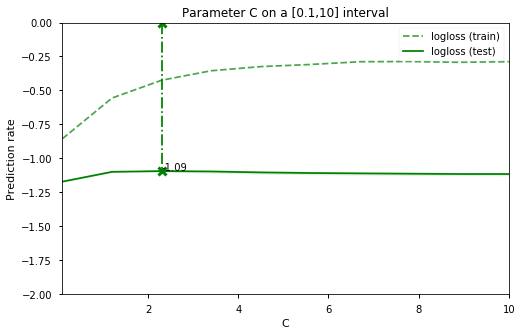

In [14]:
# plot prediction rate
%matplotlib inline
get.plot_gsearch(search, [0.1,10], [-2,0], 'Parameter C on a [0.1,10] interval', scoring)

In [15]:
# ----------OPTIMIZE SVM--------------------------
param_test2 = {
    'C':list(np.linspace(1, 3, num=10)),
}

scoring = {'logloss': 'neg_log_loss'}

search = GridSearchCV(estimator = SVC(probability=True, kernel='rbf', gamma='auto'),
                        param_grid=param_test2,
                        scoring=scoring,
                        refit='logloss',
                        n_jobs=-1,
                        iid=False,
                        return_train_score=True,
                        cv=3)

print('Estimated run time: 5 min')
search.fit(X_train,y)
print('Optimal parameters and corresponding accuracy:')
print(search.best_params_)
print(search.best_score_)

Estimated run time: 5 min
Optimal parameters and corresponding accuracy:
{'C': 2.5555555555555554}
-1.09308301294


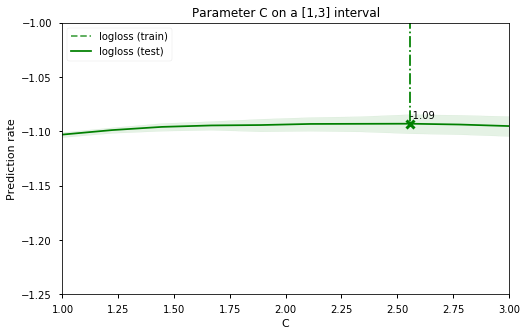

In [16]:
# plot prediction rate
%matplotlib inline
get.plot_gsearch(search, [1,3], [-1.25,-1], 'Parameter C on a [1,3] interval', scoring)

## 4. Results

Optimizing the SVM for accuracy and log-loss resulted in similar set-ups. The performance improved on both fronts when features with zero MAD-scores were excluded. The performance improved still when sPCA was performed on the data without dimension reduction. This process resulted in 241 features.

Fine tuning the SVM with GridSearchCV and with some further trial and error for an improved Kaggle-score yielded:

<style>
    .data-table {
        border-collapse: collapse;
    }
    .border-top {
        border-top: 1px solid #000;
    }
    .border-bottom {
        border-bottom: 1px solid #000;
    }
    .border-left {
        border-left: 1px solid #000;
    }
    .border-right {
        border-right: 1px solid #000;
    }
</style>

<table class="data-table">
    <tr>
        <th class="border-top border-bottom border-left border-right">Metric</th>
        <th class="border-top border-bottom border-right">gamma</th>
        <th class="border-top border-bottom border-right">C</th>
        <th class="border-top border-bottom border-right">CV-score</th>
        <th class="border-top border-bottom border-right">Kaggle-score</th>
    </tr>
    <tr>
        <td class="border-left border-right">Accuracy</td>
        <td class="border-right">'auto'</td>
        <td class="border-right">2.7</td>
        <td class="border-right">0.6546</td>
        <td class="border-right">0.6623</td>
    </tr>
    <tr>
        <td class="border-bottom border-left border-right">Log-loss</td>
        <td class="border-bottom border-right">'auto'</td>
        <td class="border-bottom border-right">1.5</td>
        <td class="border-bottom border-right">1.096</td>
        <td class="border-bottom border-right">0.1683</td>
    </tr>
</table>

The cross-validated accuracy is very similar to the accuracy in Kaggle. Whereas the cross-validated log-loss is ten times better in Kaggle which is a rather surprising result.

The set-up for accuracy yields the following confusion matrix on a retained test set.

Normalized confusion matrix


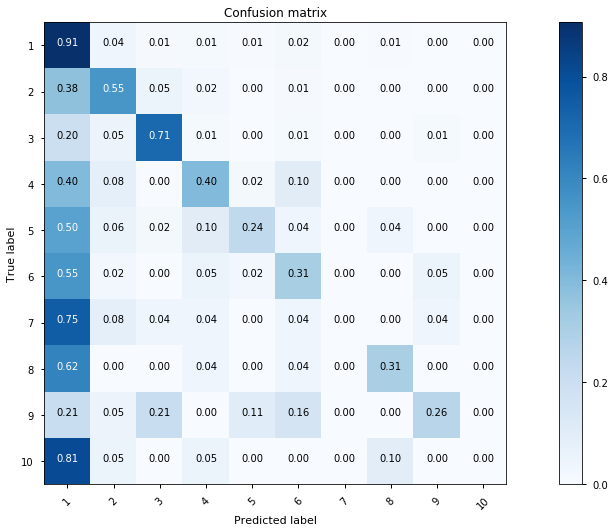

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_trimmed, y, test_size=0.2, random_state=21)

# exclude features
X_trimmed = trimByMAD(X, 0)

# scale data
X_train = preprocessing.scale(X_train)
X_test = preprocessing.scale(X_test)

# conduct sPCA
X_train = np.dot(X_train, P)
X_test = np.dot(X_test, P)

model = SVC(kernel='rbf', gamma='auto', C=2.7).fit(X_train, y_train)

# plot confusion matrix
y_true, y_pred = y_test, model.predict(X_test)
get.plot_confusion_matrix(y_true, y_pred, 1, normalize=True)

## 5. Discussion/Conclusions

The confusion matrix shows that we achieved good prediction accuracy for classes 1 and 3, decent accuracy for classes 2 and 4, and appalling accuracy for the rest of the classes. None of the classes 7 and 10 were guessed correctly and most false positives belong to class 1. This class is responsible for the main imbalance in the data. Classes 1, 7 and 10 correspond to genres pop-rock, international and blues. Since the international and blues genres are so vague by definition, it is no surprise that they are most often misclassified as pop-rock. All of the other badly classified genres are also mostly misclassified as pop-rock. This leads us to believe that the genre of pop-rock overlaps with most of the other genres in the 264 dimensional feature space. As literature suggests, this makes it diffucult for the SVM classifier to succesfully identify boundaries between the classes. We aspired to combat this issue using supervised PCA and SVM kernel methods to separate the classes. While standardization, feature selection and transformation of the data help to reduce noise and thus improve the prediction accuracy, the problem persisted to a certain degree.

Because this model strived for accuracy, it maximized the micro-averaged f1-score of class 1 in favor of other classes, explaining the left heavy confusion matrix. If the goal would have been good class-accuracy, the macro-averaged f1-score would have been used. According to literature, this would have resulted in a more diagonal heavy confusion matrix with worst overall accuracy due to class imbalance. Generally, accuracy is the worst evaluation metric for imbalanced datasets, since its primitive nature favors the majority classes. The log-loss metric is no better than accuracy, since it has similar flaws. 

To conclude, we succesfully predict the labels of the majority classes, while compromising minority class prediction accuracy. This is deemed acceptable as the data is significantly skewed and decent prediction accuracy was achieved. As discussed, the analysis suggests that the majority class 1 strongly overlaps with the minority classes. Thus, classifiers that partition the feature space such that each data point belongs to a different cluster might yield better minority class prediction accuracy. Decision trees are such classifiers and should be researched for further improvement of the classification results.

## 6. References

[1] https://mycourses.aalto.fi/course/view.php?id=20569  <br>
[2] http://scikit-learn.org/stable/  <br>
[3] https://www.analyticsvidhya.com/blog/2017/03/imbalanced-classification-problem/  <br>
[4] https://towardsdatascience.com/metrics-to-evaluate-your-machine-learning-algorithm-f10ba6e38234  <br>
[5] https://acutecaretesting.org/en/articles/precision-recall-curves-what-are-they-and-how-are-they-used  <br>
[6] https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin  <br>
[7] https://arxiv.org/pdf/1106.1813.pdf  <br>
[8] https://medium.com/james-blogs/outliers-make-us-go-mad-univariate-outlier-detection-b3a72f1ea8c7 <br>
[9] https://doi.org/10.1016/j.patcog.2010.12.015 <br>
[10] https://arxiv.org/abs/1805.05052 <br>

